In [1]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
 #Load the data
data = pd.read_csv('D:\SIH PROJECT\CGWB_data_wide.csv')

In [3]:
# Preprocessing
# Dropping irrelevant columns and renaming the unnamed index
data = data.drop(columns=['Unnamed: 0', 'WLCODE', 'SITE_TYPE'])
data.columns = data.columns.str.strip()

In [4]:
# Forward fill to handle missing values
data.ffill(inplace=True)

In [5]:
# Convert the dataset into a format for time series prediction
# Use past 3 months data to predict the next month groundwater level
def create_lag_features(df, target_column, lags):
    for lag in range(1, lags + 1):
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

In [6]:
# Encode categorical features like 'STATE' and 'DISTRICT'
label_encoder = LabelEncoder()
data['STATE'] = label_encoder.fit_transform(data['STATE'])
data['DISTRICT'] = label_encoder.fit_transform(data['DISTRICT'])


In [7]:
# We are focusing on the last groundwater level column (e.g., Jan 2017)
target_column = 'Jan 2017'

In [8]:
# Generate lag features for the past 3 months (lags)
data = create_lag_features(data, target_column, 3)

In [9]:
# Drop rows with NaN values due to lag feature creation
data.dropna(inplace=True)

In [10]:
# Split features and target
X = data.drop(columns=[target_column])
y = data[target_column]


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Model training with Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [13]:
# Prediction
y_pred = rf_model.predict(X_test)


In [14]:
 # Evaluation using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 3.244775981934671


In [15]:
# Display the actual vs predicted values for the first 10 samples
actual_vs_predicted = pd.DataFrame({'Actual': y_test.values[:10], 'Predicted': y_pred[:10]})
print(actual_vs_predicted)

   Actual  Predicted
0   32.30    32.3000
1    7.88     7.8660
2    4.20     4.0159
3    3.50     3.6954
4    6.20     4.9549
5    5.72    22.3975
6    5.85     9.9992
7    1.92     2.5804
8   15.71    15.6517
9   10.44    10.4131


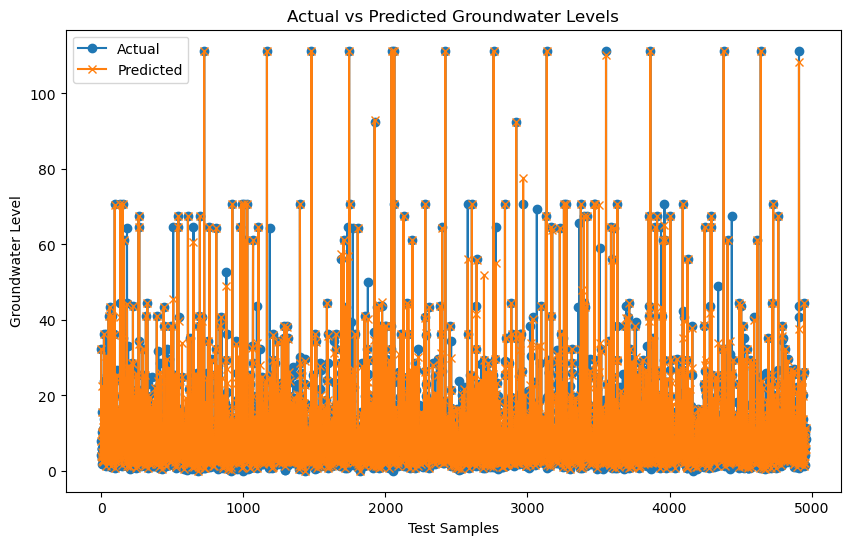

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.legend()
plt.title("Actual vs Predicted Groundwater Levels")
plt.xlabel("Test Samples")
plt.ylabel("Groundwater Level")
plt.show()

In [17]:
# Detailed results (input features, actual values, predicted values)
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
detailed_results = X_test_reset.copy()
detailed_results['Actual Groundwater Level'] = y_test_reset
detailed_results['Predicted Groundwater Level'] = y_pred


In [18]:
# Display the first 10 rows of the detailed results
print(detailed_results.head(10))

   STATE  DISTRICT        LAT        LON  May 1996  Aug 1996  Nov 1996  \
0      6       274  30.085280  77.067780     12.31      5.44     19.13   
1     20        93  13.001389  80.270000      6.90      5.06      2.80   
2      4       335  21.841670  73.466670      2.53      2.73      2.72   
3      9        74  17.913333  77.523611     17.15      6.62     13.11   
4      9       434  13.866670  75.733330      3.05      0.94      1.78   
5     13        95  21.964722  78.770278      7.90      2.86      7.57   
6      9       180  13.150000  76.227780      4.64      6.03      3.44   
7     10       362   9.416389  76.730560      4.57      4.05      5.16   
8     23       320  23.847780  88.235280      2.78      0.38      1.70   
9     22       314  28.591110  78.828060      1.91      5.90      4.21   

   Jan 1997  May 1997  Aug 1997  ...  Nov 2015  Jan 2016  May 2016  Aug 2016  \
0     18.26     20.53     22.11  ...     35.10     18.80     44.32     37.00   
1      5.02      4.09    

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Absolute Error: 1.102401189756002
Mean Squared Error: 10.52857117294011
Root Mean Squared Error: 3.244775981934671
R-squared: 0.9265874420953868


Confusion Matrix:
[[1638  268]
 [  91 2962]]


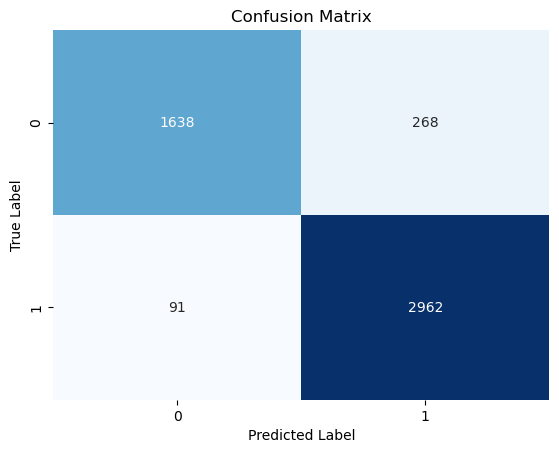

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

# Define a threshold to convert continuous target values into binary classes
threshold = 5  # Example: You can adjust this threshold based on your data

# Convert continuous target and predictions to binary (classification)
y_test_class = np.where(y_test > threshold, 1, 0)
y_pred_class = np.where(y_pred > threshold, 1, 0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


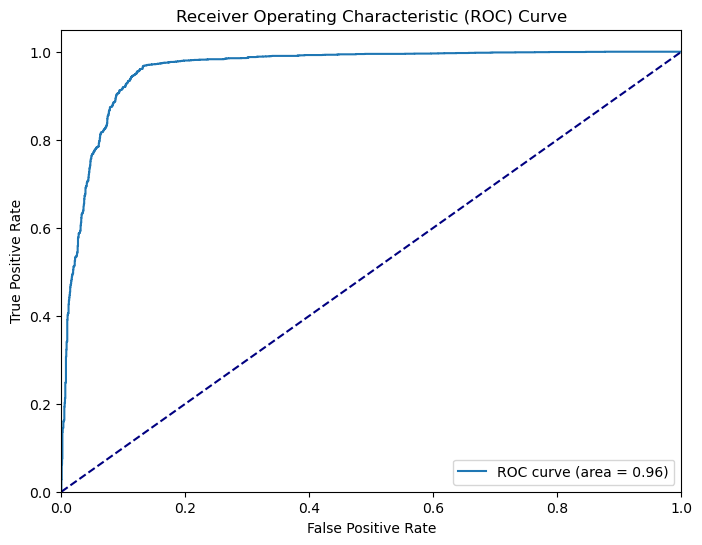

ROC AUC Score: 0.9605191975690744


In [22]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_class, y_pred)
roc_auc = roc_auc_score(y_test_class, y_pred)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc}")